In [1]:
import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
from numba import jit
from tqdm import tqdm
from matplotlib.patches import Polygon

In [2]:
"""Определение класса молекулы"""
class Molecule:
    
    # Инициализация из файла .xyz
    def __init__(self, file_name):

        self.D0 = 3.24
        self.r0 = 2.222
        self.S = 1.57
        self.betta = 1.4760
        self.gamma = 0.09253
        self.c = 1.13681
        self.d = 0.63397
        self.h = 0.335
        self.two_mu = 0
        self.R = 2.9
        self.D = 0.15
        self.m = 2912
        self.file_name = file_name

        with open(file_name, "r") as file:
            f_lines = file.readlines()
            while not f_lines[0].strip():
                f_lines.pop(0)
            self.atom_num = int(f_lines.pop(0))
            self.atom_r = {}
            line = f_lines[0].split()
            iter_char = iter(line)
            while True:
                try:
                    element = next(iter_char)
                    radius = next(iter_char)
                    self.atom_r[element] = float(radius)
                except StopIteration:
                    break
            f_lines.pop(0)
            n = 0
            self.atom_el = ['0']*self.atom_num
            self.atom_coords = [0]*self.atom_num
            for line in f_lines:
                if line.strip():
                    array = line.split()
                    self.atom_el[n] = array.pop(0)
                    self.atom_coords[n] = np.fromstring(' '.join(array), sep=' ')
                    n+=1
                else: break
            self.atom_coords = np.array(self.atom_coords)
    
    # Изменить одну из координат на шаг step для atom
    def move_i_coord(self, step, atom, coord):
        new_coords = self.atom_coords[atom].copy()
        new_coords[coord] = new_coords[coord] + step
        self.atom_coords[atom] = new_coords

    # Изменить все координаты на шаг step для atom
    def move_coords(self, step, atom):
        new_coords = self.atom_coords[atom].copy()
        new_coords = new_coords + step
        self.atom_coords[atom] = new_coords

    # Изменить одну из координат на значение new_coord
    def change_i_coord(self, new_coord, atom, coord):
        self.atom_coords[atom][coord] = new_coord
    

    # Изменить координаты на значение new_coords
    def change_coords(self, new_coords):
        self.atom_coords = new_coords 
        return self         

    # Копировать молекулу    
    def copy(self):
        new_mol = Molecule(self.file_name)
        new_mol.atom_el = self.atom_el.copy()
        new_mol.atom_coords = self.atom_coords.copy()
        new_mol.atom_num = self.atom_num
        new_mol.atom_r = self.atom_r.copy()
        return new_mol

    # Определение граничных координат молекулы
    def box(self):
        x_max = 0
        y_max = 0
        z_max = 0
        for num in range(self.atom_num):
            atom_max_x = self.atom_coords[num][0] + self.atom_r[self.atom_el[num]]
            atom_max_y = self.atom_coords[num][1] + self.atom_r[self.atom_el[num]]
            atom_max_z = self.atom_coords[num][2] + self.atom_r[self.atom_el[num]]
            if atom_max_x > x_max:
                x_max = atom_max_x
            if atom_max_y > y_max:
                y_max = atom_max_y
            if atom_max_z > z_max:
                z_max = atom_max_z
        
        x_min = 0
        y_min = 0
        z_min = 0
        for num in range(self.atom_num):
            atom_min_x = self.atom_coords[num][0] - self.atom_r[self.atom_el[num]]
            atom_min_y = self.atom_coords[num][1] - self.atom_r[self.atom_el[num]]
            atom_min_z = self.atom_coords[num][2] - self.atom_r[self.atom_el[num]]
            if atom_min_x < x_min:
                x_min = atom_min_x
            if atom_min_y < y_min:
                y_min = atom_min_y
            if atom_min_z < z_min:
                z_min = atom_min_z

        self.x_max = x_max
        self.y_max = y_max
        self.z_max = z_max

        self.x_min = x_min
        self.y_min = y_min
        self.z_min = z_min
        self.box_volume = (self.x_max - self.x_min) * (self.y_max - self.y_min) * (self.z_max - self.z_min)
        self.box_min = min([self.x_max, self.y_max, self.z_max, self.x_min, self.y_min, self.z_min])

        return [self.x_max, self.y_max, self.z_max, self.x_min, self.y_min, self.z_min]

    # Вывод молекулы через print()
    def __str__(self):
        string = "{}\n".format(self.atom_num)
        for key in self.atom_r:
            string += "{} {}\n".format(key, self.atom_r[key])
        for i in range(self.atom_num):
            string += "{} {:.5f} {:.5f} {:.5f}\n".format(self.atom_el[i], self.atom_coords[i][0], self.atom_coords[i][1], self.atom_coords[i][2])
        return(string)

    def vol(self, vol, d):
        self.vol = {"value": vol, "d": d}    
    # def r_ij(self):
    #     self.r = np.array([[np.linalg.norm(self.atom_coords[j] - self.atom_coords[i]) for j in range(self.atom_num)] for i in range(self.atom_num)])
    #     return self.r
    
    # Вывод молекулы в файл
    def printToFile(self, file_name):
        if file_name != "None":    
            old_lines = ""
            with open(file_name, "r") as file:
                old_lines = file.read()
            with open(file_name, "w") as file:
                print(self, file=file)
                print(old_lines, file=file)
            
# Класс точки для задания коробки    
class Dot:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def random(self, x_low, x_high, y_low, y_high, z_low, z_high):
        self.x = random.uniform(x_low, x_high)
        self.y = random.uniform(y_low, y_high)
        self.z = random.uniform(z_low, z_high)

    def next(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z


In [3]:
# Задача 1
"""Поиск описанного вокруг молекулы параллелепипеда"""

# Проверка, что точка принадлежит молекуле
def dotInside(dot, mol, n):
    if (
        (dot.x - mol.atom_coords[n][0]) ** 2
        + (dot.y - mol.atom_coords[n][1]) ** 2
        + (dot.z - mol.atom_coords[n][2]) ** 2
    ) <= mol.atom_r[mol.atom_el[n]] ** 2:
        return True
    return False

# Определение объема молекулы
def volume(M):
    dot = Dot(0, 0, 0)
    box = M.box()
    dot_full = 1000
    iter_num = 100
    values = np.zeros(iter_num)
    for n in range(iter_num):
        dot_inside = 0
        for i in range(dot_full):
            dot.random(M.x_min, M.x_max, M.y_min, M.y_max, M.z_min, M.z_max)
            inside = False
            for num in range(M.atom_num):
                if dotInside(dot, M, num):
                    inside = True
                    break
            if inside:
                dot_inside += 1
        values[n] = dot_inside / dot_full * M.box_volume

    average = np.average(values)
    std = np.std(values)
    t = 1.984
    d = std * t
    print(
        "Molecule Volume = ({:.2f}+-{:.2f})A, E = {:.2f}, alpha = 0.95".format(
            average, d, d / average
        )
    )
    return average  

In [4]:
# Задача 2
"""Определение потенциальной энергии молекулы"""

# Определение энергии молекулы
#Включает кучу вспомогательных функций, входящих в состав расчета энергии, а также @jit функции для ускорения процессов
def E(mol):
    r = r_ij(mol)
    V_r = Vr(mol, r)
    V_a = Va(mol, r)
    f_c = np.array([[fc(mol, r[i, j]) 
            if i != j else 0 
            for j in range(mol.atom_num)] 
                for i in range(mol.atom_num)])
    vector = np.array([[mol.atom_coords[j] - mol.atom_coords[i] 
            if i != j else np.zeros(3) 
            for j in range(mol.atom_num)] 
                for i in range(mol.atom_num)])
    g_ = g(mol, r, vector)
    b_ = b(mol, r, f_c, g_)
    E = [f_c[i, j] * (V_r[i, j] - (b_[i, j] + b_[j, i]) / 2 * V_a[i, j]) 
        if (i < j and f_c[i, j] != 0) else 0 
            for i in range(mol.atom_num) 
            for j in range(mol.atom_num)]
    return np.sum(E)

def r_ij(mol):
    r_ij = R_ij(mol.atom_coords, mol.atom_num)
    return r_ij

@jit(nopython=True)
def R_ij(atom_coords, atom_num):
    r = np.zeros((atom_num, atom_num))
    for i in range(atom_num):
        for j in range(atom_num):
            r[i,j] = np.linalg.norm(atom_coords[j] - atom_coords[i])
    return r

def Vr(mol, r):
    return np.array([[mol.D0 / (mol.S - 1) * math.exp(-mol.betta * (2 * mol.S) ** (1/2) * (r[i, j] - mol.r0))
                if i < j else 0 for j in range(mol.atom_num)] for i in range(mol.atom_num)])

def Va(mol, r):
    return np.array([[mol.S * mol.D0 / (mol.S - 1) * math.exp(-mol.betta * (2/mol.S) ** (1/2) * (r[i, j] - mol.r0))
                if i < j else 0 for j in range(mol.atom_num)] for i in range(mol.atom_num)])

def fc(mol, r):
    if r < mol.R - mol.D:
        return 1
    elif abs(mol.R - r) <= mol.D:
        return 1/2  - 1/2 * math.sin(math.pi * (r-mol.R) / (2 * mol.D))
    elif mol.R + mol.D < r:
        return 0
    
def b(mol, r, fc, g):
    atom_num = mol.atom_num
    b = B(r, fc, g, atom_num)
    return b

@jit(nopython=True)
def B(r, fc, g, atom_num):
    b = np.zeros((atom_num, atom_num))
    for i in range(atom_num):
        for j in range(atom_num):
            if i!= j:
                b_k = np.zeros(atom_num)
                for k in range(atom_num):
                    if k != i and k != j:
                        b_k[k] = fc[i, k] * g[i, j, k]
                b[i, j] = (np.sum(b_k) + 1) ** (-1/2)
    return b

def g(mol, r, vector):
    c = mol.c
    d = mol.d
    h = mol.h
    gamma = mol.gamma
    atom_num = mol.atom_num
    g = G(r, vector, c, d, h, gamma, atom_num)
    return g

@jit(nopython=True)
def G(r, vector, c, d, h, gamma, atom_num):
    g = np.zeros((atom_num, atom_num, atom_num), dtype=np.float64)
    for i in range(atom_num):
        for j in range(atom_num):
            for k in range(atom_num):
                if k != i and k != j and i != j:
                    g[i, j, k] = gamma * (1 + (c / d) ** 2 - c ** 2 / (d ** 2 + (h + np.dot(vector[i, j], vector[i, k]) / (r[i, j] * r[i, k])) ** 2))
    return g

In [5]:
# Задача 3
"""Релаксация молекулы (определение минимальной энергии)"""

# Расчет градиента энергии в точке атома
def grad(mol, atom):
    delta = 0.001
    grad = np.zeros(3)
    mol_up = mol.copy()
    mol_down = mol.copy()
    for i in range(3):
        mol_up.move_i_coord(delta, atom, i)
        mol_down.move_i_coord(-delta, atom, i)
        grad[i] = (E(mol_up) - E(mol_down)) / (2 * delta)
        mol_up = mol.copy()
        mol_down = mol.copy()
    return grad

# Расчет силы, действующей на атом
def F(mol, atom):
    F = - grad(mol, atom)
    return F

# Расчет сил, действующих на все атомы
def fullF(mol):
    f = np.zeros((mol.atom_num, 3))
    for atom in range(mol.atom_num):
        f[atom] = F(mol, atom)
    return f

# Релаксация молекулы
def relaxate(mol, file_name="None", low_f = 0.01):
    sum_f = 1
    f = np.zeros((mol.atom_num, 3))
    n = 0
    while sum_f - low_f > 0:
        sum_f = 0
        for i in range(mol.atom_num):
            f[i] = F(mol, i)
            sum_f += np.linalg.norm(f[i])
        mol.atom_coords += 0.01 * f
        n += 1
        if n%100 == 0:
            print(n, sum_f)
            mol.printToFile(file_name)
    print('E = ', E(mol))
    return mol

In [6]:
# Задача 5
"""Построение графика зависимости расширения молекулы от температуры"""

# Определение начальной скорости атомов при температуре T
def velocity(T, n, m):
    phi = random.uniform(0, 2 * np.pi)
    r = random.uniform(0.0000001, 1)

    ro = np.sqrt(-2*np.log(r))
    x =  ro * np.cos(6.28 * phi)
    
    k = 0.00008617
    mu = 0
    sigma = np.sqrt(2 * k * T / m)
    
    y = mu + sigma * x
    return y

# Определение всех начальных скоростей атомов
def find_velocities(mol, T, m):
    velocities = np.zeros((mol.atom_num, 3))
    for atom in range(mol.atom_num):
        for i in range(3):
            velocities[atom][i] = velocity(T, mol.atom_num, m)
    return velocities

# Исследование обьема молекулы при температуре T
def volumeT(molecule, T):
    m = molecule.m
    velocities = find_velocities(molecule, T, m)
    dtime = 1
    vf = f = relaxate(molecule, molecule.file_name)
    volumes = np.zeros(50)
    mol = molecule.copy()

    for t in range(10000):
        mol.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f
        f= fullF(mol)
        velocities += 0.5 * dtime * (vf + f) / m

        if t%200 == 0:
            volumes[int(t/200)-1] = volume(mol)
    
    return np.mean(volumes)

In [7]:
# Задача 6
"""Определение температуры распада молекулы"""

# Исследование молекулы при температуре T за время t=10000
def thermalTest(molecule, T):
    m = molecule.m
    velocities = find_velocities(molecule, T, m)
    dtime = 1
    f = np.zeros([10, 3])
    vf = f
    mol = molecule.copy()

    for t in range(10000):
        mol.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f

        f = fullF(mol)
        velocities += 0.5 * dtime * (vf + f) / m

        if t%500 == 0:
            print(t, end = " ")

    return mol

# Исследование молекулы на условие распада
def checkEquality(mol_base, mol):
    relaxate(mol, mol.file_name)
    if np.abs(E(mol_base) - E(mol)) < 0.001:
            return "Molecule is ok"
    return "Molecule has been desintegrated"

# Тест на термическое сопротивление
def thermalResistance(mol, temp):
    mol_base = mol.copy()
    mol = thermalTest(mol, temp)
    mol.printToFile("DataEx6.xyz")
    print(checkEquality(mol_base, mol))
    print(mol)
    return mol

In [8]:
# Задача 7
"""Исследование столкновения двух молекул"""
# Определение начальных скоростей
def launch_velocities(mol, base_velocity):
    velocities = np.zeros((mol.atom_num, 3))
    for atom in range(mol.atom_num):
        if atom < mol.atom_num/2:
            velocities[atom][0] = base_velocity
        else:
            velocities[atom][0] = -base_velocity
    return velocities

#Стартовая функция столкновения (с релаксацией перед началом)
def collision(molecules, base_vel):
    n_max = 500
    dtime = 1
    print_iter = dtime * 10
    m = molecules.m
    velocities = launch_velocities(molecules, base_vel)
    vf = f = relaxate(molecules, molecules.file_name, 0.2)
    volumes = np.zeros(50)
    mol = molecules.copy()
    start_time = time.time()
    last_time = 0
    for t in range(0, n_max, dtime):
        mol.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f

        f= fullF(mol)
        velocities += 0.5 * dtime * (vf + f) / m

        if t%print_iter == 0:
            mol.printToFile("DataEx7.xyz")
            new_time = (time.time()-start_time)
            time_left = n_max / print_iter * (new_time - last_time) - new_time
            print("{} min {} sec: {} of {} - {} min left".format(int(new_time//60), int(new_time%60), t, n_max, int(time_left//60)))
            last_time = new_time
    
    return mol

# Функция запуска столкновения без релаксации
def collision_continue(molecules, base_vel):
    n_max = 10000
    iter_t = 10
    m = molecules.m
    velocities = launch_velocities(molecules, base_vel)
    dtime = 1
    volumes = np.zeros(50)
    molecules = molecules.copy()
    f= fullF(molecules)
    start_time = time.time()
    last_time = 0
    for t in range(0, n_max, iter_t):
        molecules.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f

        f= fullF(molecules)
        velocities += 0.5 * dtime * (vf + f) / m

        if t%50 == 0:
            molecules.printToFile("/content/DataEx7.xyz")
            new_time = (time.time()-start_time)
            time_left = n_max / iter_t * (new_time - last_time) - new_time
            print("{} min {} sec: {} of {} - {} min left".format(int(new_time//60), int(new_time%60), t, n_max, int(time_left//60)))
            last_time = new_time
    
    return molecules

In [9]:
#Задача 8 (8 семестр)
"""Построение графика зависимости напряжение от деформации"""

# Деформация молекулы по оси X (растяжение)
def deform(mol, eps=0):
    for i in range(mol.atom_num):
        mol.atom_coords[i][0] = mol.atom_coords[i][0] * (1 + eps)
    return mol

# Релаксация молекулы c зафиксированными атомами
def fixed_relaxate(mol, low_f = 0.01):
    sum_f = 1
    f = np.zeros((mol.atom_num, 3))
    n = 0
    while sum_f - low_f > 0:
        sum_f = 0
        for i in range(mol.atom_num):
            # Задаем атомы, которые нужно зафиксировать
            if i not in (2, 4, 8, 9):
                f[i] = F(mol, i)
                sum_f += np.linalg.norm(f[i])
        mol.atom_coords += 0.01 * f
        n += 1
    return f

# Расчет напряжения
def calc_stress(mol):
    S = 10
    f = np.array([np.abs(F(mol, i)[0]) for i in (2, 4, 8, 9)])
    return np.sum(f) / (4 * S) 

# Построение графика зависимости напряжения от деформации
def stress_deformation_graph(mol):
    epses = np.arange(0, 0.8, 0.05)
    sigmas = np.zeros(np.size(epses))
    i = 0
    for eps in tqdm(epses):
        mol_test = mol.copy()
        deform(mol_test, eps)
        fixed_relaxate(mol_test)
        sigmas[i] = calc_stress(mol_test)
        i+=1

    fig, ax = plt.subplots()
    ax.plot(epses, sigmas)    
    ax.scatter(epses, sigmas)    



In [10]:
# Задача 9
"""Построение графика зависимости потока от разницы температур"""

# Релаксация молекулы по определенной оси N
def relaxate_axis(mol, axis="X", low_f = 0.01):
    sum_f = 1
    f = np.zeros((mol.atom_num, 3))
    if axis.lower() == "x":
        ax = 0
    elif axis.lower() == "y":
        ax = 1
    elif axis.lower() == "z":
        ax = 2
    n = 0
    while sum_f - low_f > 0:
        sum_f = 0
        for i in range(mol.atom_num):
            f[i][ax] = F(mol, i)[ax]
            sum_f += np.linalg.norm(f[i])
        mol.atom_coords += 0.01 * f
        n += 1
        if n%10 == 0:
            print(n, sum_f)
            mol.printToFile("DataEx9.xyz")
    print('E = ', E(mol))
    return mol

# Вычисление потока для определенной разницы температур
def calc_flow(mol, dT):
    T = 300
    kb = 0.00008617
    m = mol.m
    velocities = find_velocities(mol, 2*T, m)
    dtime = 1
    f = np.zeros([mol.atom_num, 3])
    vf = f
    K_must_first = 3 * 3/2 * kb * (T + dT)
    K_must_last = 3 * 3/2 * kb * (T - dT)
    J = np.zeros((10, 2))
    for t in tqdm(range(100)):
        if t%10 == 0:
            K_first = m/2  * (np.linalg.norm(velocities[0]) ** 2 + np.linalg.norm(velocities[1]) ** 2 + np.linalg.norm(velocities[2]) ** 2)
            k_first = np.sqrt(K_must_first / K_first)
            K_last = m/2  * (np.linalg.norm(velocities[-1]) ** 2 + np.linalg.norm(velocities[-2]) ** 2 + np.linalg.norm(velocities[-3]) ** 2)
            k_last = np.sqrt(K_must_last / K_last)
            J[int(t/10), 0] = K_must_first - K_first
            J[int(t/10), 1] = K_must_last - K_last
            for i in range(3):
                velocities[i] = velocities[i] * k_first
                velocities[-i-1] = velocities[-i-1] * k_last

        mol.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f
        f = fullF(mol)
        velocities += 0.5 * dtime * (vf + f) / m
    return J

# Построение графика зависимости потока от разницы температур
def flow_graph(mol):
    dT = [20, 40, 60, 80, 100]
    Js = np.zeros(5)
    for dt in dT:
        mol_test = mol.copy()
        Js[int(dt/20)-1] = np.mean(calc_flow(mol_test, dt))
    
    fig, ax = plt.subplots()
    ax.plot(dT, Js)    
    ax.scatter(dT, Js)

In [11]:
# Задача 10
"""Построение графика зависимости количества теплоты, сообщенного системе, от температуры системы (поиск температуры плавления)"""

# Определение всех начальных скоростей атомов (модули всех скоростей равны, направления случайны)
def find_fixed_velocities(mol, Q, m):
    kb = 0.00008617
    velocities = np.zeros((mol.atom_num, 3))
    v = np.sqrt(Q / (m /2  * mol.atom_num))
    for atom in range(mol.atom_num):
        for i in range(3):
            velocities[atom][i] = velocity(100, mol.atom_num, m)
        velocities[atom] *= v / np.linalg.norm(velocities[atom])
    return velocities

# Вычисление температуры системы при прередаче системе определенного тепла и ожидания 1000 фс
def calc_T_Q(molecule, Q):
    mol = molecule.copy()
    m = mol.m
    kb = 0.00008617
    velocities = find_fixed_velocities(mol, Q, m)
    dtime = 1
    f = np.zeros([mol.atom_num, 3])
    vf = f
    for t in range(1000):
        mol.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f
        f = fullF(mol)
        velocities += 0.5 * dtime * (vf + f) / m
    T = m * np.sum(velocities ** 2) / (3 * mol.atom_num * kb)
    return [Q, T]

# Обновить кэш в файле
def update_cache(data, file_path):
    if not os.path.exists(file_path):
        file = open(file_path, "w+")
        file.close()
    np.savetxt(file_path, data)

# Загрузить кэш из файлов
def load_cache(file_path):
    try:
        data = np.genfromtxt(file_path)
    except (FileNotFoundError, IOError):
        print("load_cache() can't find file: No file in directory")
        data = np.array([])
    return data

# Очистить кэш из файла
def clear_cache(file_path):
    data = load_cache(file_path)
    update_cache([], file_path)
    return data

# Поиск среднего значения температуры для каждого значения Q
def find_average_Q_T(cache_file):
    Q_T_data = load_cache(cache_file)
    Q_T_sort = Q_T_data[np.argsort(Q_T_data[:, 0])]
    unique_Q, first_index_Q, count_Q = np.unique(np.round(Q_T_sort.T[0], 10), return_index=True, return_counts=True, axis=0)
    Ts = np.zeros((unique_Q.size, count_Q.max()))
    for i in range(Ts.shape[0]):
        for j in range(count_Q[i]):
            Ts[i][j] = Q_T_sort.T[1][first_index_Q[i]+j]
    Q_T_unique = np.array([[unique_Q[i], np.average([Ts[i][j] for j in np.nonzero(Ts[i])]), np.std([Ts[i][j] for j in np.nonzero(Ts[i])])] for i in range(unique_Q.shape[0])])
    return Q_T_unique

# Построение графика зависимости количества теплоты, сообщеного системе от температуры системы    
def Q_T_plot(mol, Q_step, Q_min=0, Q_max=25, enable_cache=True, repeats=1):
    cache_file = "/content/DataEx10_cache.txt"
    n_dots = (Q_max - Q_min) // Q_step
    Q_T_data = np.array([calc_T_Q(mol, Q) for Q in tqdm(np.arange(Q_min, Q_max, Q_step), f"Run 1 of {repeats}", position=0, leave=True)])
    for i in range(repeats-1):
        Q_T_data = np.concatenate((Q_T_data, np.array([calc_T_Q(mol, Q) for Q in tqdm(np.arange(Q_min, Q_max, Q_step), f"Run {i+2} of {repeats}", position=0, leave=True)])))
    if enable_cache == True:
        Q_T_cache = load_cache(cache_file)
        if Q_T_cache.size > 1:
            Q_T_data = np.concatenate((Q_T_data, Q_T_cache))
        update_cache(Q_T_data, cache_file)
        Q_T_unique = find_average_Q_T(cache_file)
        fig, ax = plt.subplots()   
        ax.scatter(Q_T_unique.T[1], Q_T_unique.T[0])
    else:
        fig, ax = plt.subplots()   
        ax.scatter(Q_T_data.T[1], Q_T_data.T[0])
    return Q_T_data

    

In [12]:
# Задача 11
"""Построение графика спектра молекулы"""

# Расчет второй производной по i и j переменным
def second_deriv_E(mol, i, j):
    delta = 0.001
    atom_i, coord_i = (i // 3, i % 3)
    atom_j, coord_j = (j // 3, j % 3)
    mol_move = mol.copy()
    mol_move.move_i_coord(delta, atom_i, coord_i)
    mol_move.move_i_coord(-delta, atom_j, coord_j)
    E_ul = E(mol_move)
    mol_move.move_i_coord(-2*delta, atom_i, coord_i)
    E_dl = E(mol_move)
    mol_move.move_i_coord(2*delta, atom_j, coord_j)
    E_dr = E(mol_move)
    mol_move.move_i_coord(2*delta, atom_i, coord_i)
    E_ur = E(mol_move)
    second_deriv = ((E_ur - E_ul) - (E_dr - E_dl))/(4 * delta ** 2)
    return second_deriv

# Расчет матрицы вторых производных энергии
def second_deriv_E_matrix(mol):
    sd_matrix = np.array([[second_deriv_E(mol, i, j) for i in range(3*mol.atom_num)] for j in range(3*mol.atom_num)])
    return sd_matrix

# Расчет точек на графике спектра
@jit(nopython=True)
def spectrum_vals(omegas, min_val, max_val, dots):
    sigma = 10
    sum_of_gausses = 0
    spectrum_dots = np.empty(dots)
    omega_dots = np.arange(min_val, max_val, (max_val-min_val)/dots)
    i = 0
    for omega in omega_dots:
        for omega_k in omegas:
            sum_of_gausses += 1/(2 * np.pi * sigma) * np.exp(-(omega - omega_k) ** 2 / (2 * sigma ** 2))
        spectrum_dots[i] = sum_of_gausses
        sum_of_gausses = 0
        i += 1
    return (spectrum_dots, omega_dots)

# Построение спектра молекулы
def spectrum_plot(mol, dots):
    sd_matrix = second_deriv_E_matrix(mol)
    eigen_values = np.linalg.eig(sd_matrix)[0]
    omegas = np.array([(1 / mol.m) * abs(eigen_values[i]) ** 0.5 * (10 ** 15) / (3 * 10 ** 9) for i in range(eigen_values.size) if np.abs(eigen_values[i]) > 0.01])
    min_val = omegas.min() * 0
    max_val = omegas.max() * 1.1
    spectrum_dots, omega_dots = spectrum_vals(omegas, min_val, max_val, dots)
    fig, ax = plt.subplots()   
    ax.plot(omega_dots, spectrum_dots)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    ax.set_title('Спектр')
    # ax.set_xlabel('omega')
    # ax.set_ylabel('spectre')


In [13]:
# Задача 12
"""Определение энергий активациии и реакции и построение графика энергетического перехода от 57 к 66"""

def molecule_transformation_plot(mol_a, mol_b, steps=100):
    energies = np.zeros(steps)
    alphas = np.arange(0, 1, 1/steps)
    new_coords = np.array([(1 - alpha) * mol_a.atom_coords + alpha * mol_b.atom_coords for alpha in alphas])
    mol = mol_a.copy()
    energies = np.array([E(mol.change_coords(coords)) for coords in new_coords])
    fig, ax = plt.subplots()   
    ax.plot(alphas, energies)
    ax.scatter([alphas[0], alphas[np.argmax(energies)], alphas[-1]], [energies[0], np.max(energies), energies[-1]])
    # ax.axhline(energies[0], color="black")
    fig.set_figwidth(12)
    fig.set_figheight(7)
    ax.set_xlabel('alpha')
    ax.set_ylabel('energy')
    ax.grid()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(-30, -19, 1))
    ax.text(alphas[0], energies[0] + 0.5, np.round(energies[0], 2), size=14)
    ax.text(alphas[-1]-0.05, energies[0] + 0.5, np.round(energies[-1], 2), size=14)
    ax.text(alphas[np.argmax(energies)]-0.03, np.max(energies) + 0.2, np.round(np.max(energies), 2), size=14)
    verts = [(-0.2, energies[-1]), (-0.2, energies[0]), (1.2, energies[0]), (1.2, energies[-1])]
    poly = Polygon(verts, facecolor ='red',
                edgecolor ='0.5', alpha = 0.2)
    ax.add_patch(poly)

    ax.text(alphas[np.argmax(energies)]-0.075, (np.max(energies) + energies[0]) / 2, f"Ea = {np.round(np.max(energies) - energies[0], 2)}", size=20, color="green")
    ax.text(alphas[np.argmax(energies)]-0.075, energies[0] + 0.5, f"Eр = {np.round(energies[-1] - energies[0], 2)}", size=20, color="red")



In [14]:
# Задача 13
"""Построение графика спектра молекулы с помощью автокорреляционной функции скорости"""

# Определение всех начальных скоростей атомов только по оси X
def find_velocities_x(mol, T):
    velocities = np.zeros((mol.atom_num, 3))
    for atom in range(mol.atom_num):
        velocities[atom][0] = velocity(T, mol.atom_num, mol.m)
    return velocities

# Запуск алгоритма Верле при определенной температуре и запись скоростей по оси x
def run_verlet_algorithm(molecule, T, time):
    velocities = find_velocities_x(molecule, T)
    dtime = 1
    vf = f = np.zeros([molecule.atom_num, 3])
    volumes = np.zeros(50)
    mol = molecule.copy()
    V = np.zeros((time, time))
    m = mol.m
    for t in tqdm(range(time)):
        mol.atom_coords += velocities * dtime + 0.5 * f * dtime ** 2 / m
        vf = f
        f = fullF(mol)
        velocities += 0.5 * dtime * (vf + f) / mol.m
        V[t, 0] = velocities[0][0]
        V[t, 1] = velocities[1][0]
    return V

# Расчет автокорреляционной функции
def calculate_AKF(V):
    AKF = np.array([np.mean([V[t, 0] * V[t + tau, 0] + V[t, 1] * V[t + tau, 1] for t in np.arange(100, V.shape[0]-2000+1, 100)]) for tau in np.arange(2, 1000+1, 2)])
    return AKF

# Расчет преобразования Фурье для определенной частоты
def calculate_fourier(omega, func: np.array):
    return np.array(np.sum([1 / np.sqrt(2) * np.cos(omega * t) * func[int(t/2-1)] * 2 for t in range(2, 1000, 2)]))

# Запуск всех расчетов и построение спектра молекулы
def spectrum_plot_AKF(mol):
    V = run_verlet_algorithm(mol, 100, 12000)
    AKF = calculate_AKF(V)
    omegas = np.arange(1000)
    spectrum = np.array([calculate_fourier(omega, AKF) for omega in omegas])
    fig, ax = plt.subplots()   
    ax.plot(omegas, spectrum)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    ax.set_title('Спектр')

100%|██████████| 12000/12000 [00:32<00:00, 365.15it/s]


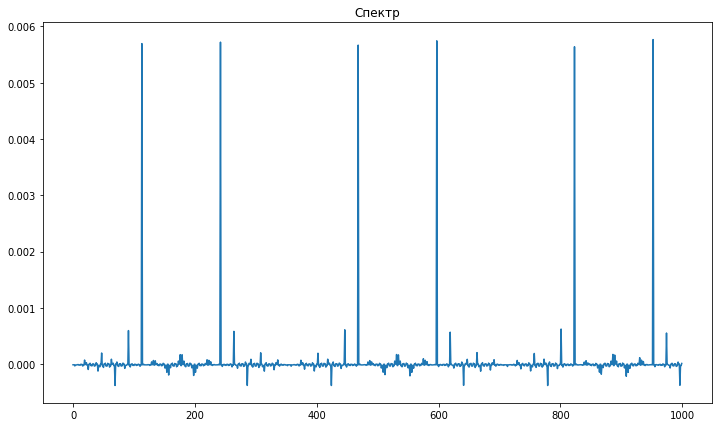

In [ ]:
mol = Molecule("/content/DataEx13.xyz")
spectrum_plot_AKF(mol)

In [23]:
def graph_from_file(file):
    data = np.genfromtxt(file, delimiter=",")
    X = data.T[0]
    Y = data.T[1]
    fig, ax = plt.subplots()   
    ax.plot(X, Y)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    ax.set_title('Спектр')

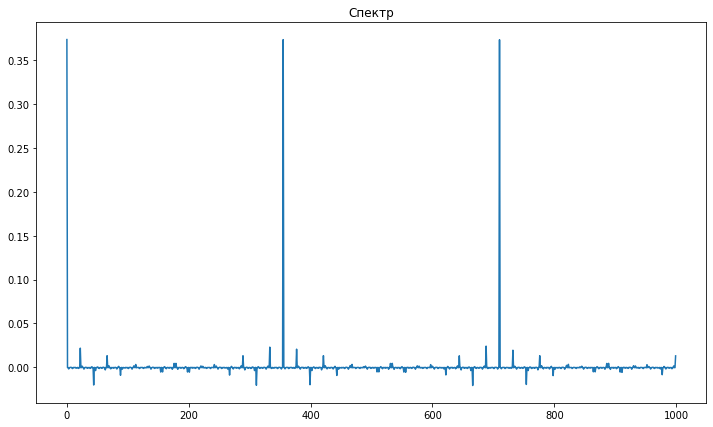

In [24]:
graph_from_file("/content/1.txt")